In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [447]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

import torch
from torch import Tensor
from torch import nn

plt.rcParams["image.cmap"] = "copper"  # For immersive Mars vibe

In [400]:
x_train = pd.read_csv("./train_damaged.csv")
x_train.index = x_train.pop("Id")
x_train = x_train.to_numpy().reshape(-1, 50, 50)

y_train = pd.read_csv("./train_undamaged.csv")
y_train.index = y_train.pop("Id")
y_train = y_train.to_numpy().reshape(-1, 100, 100)

x_val = pd.read_csv("./train_damaged.csv")
x_val.index = x_val.pop("Id")
x_val = x_val.to_numpy().reshape(-1, 50, 50)

In [402]:
x_train, x_test = x_train[:160],x_train[160:]
y_train, y_test = y_train[:160],y_train[160:]

In [468]:
def downsize(a):
    if a.shape == (100,100):a = a.reshape((1,100,100))
    assert a.shape[1:] == (100,100)

    xaxis = np.arange(0,100,2).reshape(-1,1)
    yaxis = np.arange(0,100,2)
    return (a[:,xaxis,yaxis] + 
           a[:,xaxis+1,yaxis]+
           a[:,xaxis,yaxis+1]+
           a[:,xaxis+1,yaxis+1])/4

 epoch 0 batch 152/160 avg train loss: 0.010172 test loss: 0.17787
 epoch 1 batch 152/160 avg train loss: 0.010373 test loss: 0.087404
 epoch 2 batch 152/160 avg train loss: 0.010475 test loss: 0.051214
 epoch 3 batch 152/160 avg train loss: 0.010537 test loss: 0.037426
 epoch 4 batch 152/160 avg train loss: 0.010585 test loss: 0.032207
 epoch 5 batch 152/160 avg train loss: 0.010626 test loss: 0.030158
 epoch 6 batch 152/160 avg train loss: 0.010665 test loss: 0.029249
 epoch 7 batch 152/160 avg train loss: 0.010703 test loss: 0.028746
 epoch 8 batch 152/160 avg train loss: 0.010739 test loss: 0.028386
 epoch 9 batch 152/160 avg train loss: 0.010775 test loss: 0.028081
 epoch 10 batch 152/160 avg train loss: 0.010809 test loss: 0.027798
 epoch 11 batch 152/160 avg train loss: 0.010843 test loss: 0.027528
 epoch 12 batch 152/160 avg train loss: 0.010877 test loss: 0.027267
 epoch 13 batch 152/160 avg train loss: 0.010909 test loss: 0.027014
 epoch 14 batch 152/160 avg train loss: 0.010

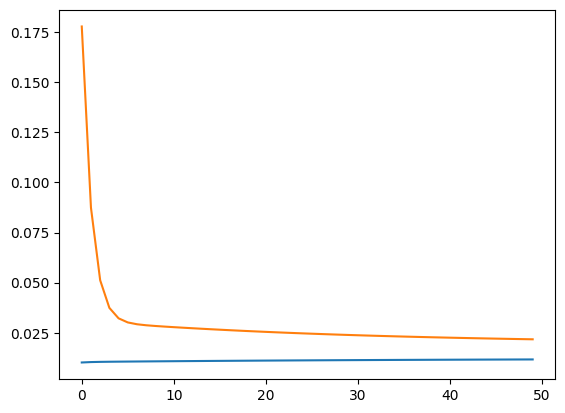

In [530]:
Loss = torch.nn.MSELoss()
class Model:

    def __init__(self):
        input_dim, hidden_dim, output_dim = 2500,5000,2500

        self.l1 = nn.Linear(input_dim, hidden_dim )
        self.l2 = nn.Linear(hidden_dim,output_dim)
        self.parameters = [*self.l1.parameters(), *self.l2.parameters()]

        # self.l1 = nn.Linear(input_dim, output_dim )
        # self.parameters = [*self.l1.parameters()]

    
    def __call__(self,x):
        x = Tensor(x).reshape(-1,2500)

        x = self.l1(x)
        x = nn.functional.relu(x)
        x = self.l2(x)

        # x = self.l1(x)
        return x

model = Model()
opt = torch.optim.Adam(model.parameters,lr=0.00001)

Loss = nn.MSELoss()
def loss_fn (p,y):
    y = Tensor(downsize(y)).reshape(-1,2500)

    return Loss(y,p)
    
def train_step(x,y):

    pred = model(x)
    loss = loss_fn(pred,y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    global hist
    hist.append(loss.detach().numpy())


loss_hist = []

def test ():
    loss = 0
    for x,y in zip(x_test,y_test):
        loss += loss_fn(model(x),y)
    return loss / x_test.shape[0]

def epoch (e=0):
    xlen = x_train.shape[0]
    batch_size = 8
    for i in range(0,xlen,batch_size):

        x,y = x_train[i:i+batch_size],y_train[i:i+batch_size]
        print (f'\r epoch {e} batch {i}/{x_train.shape[0]} ',end="")
        
        train_step(x,y)

def train(epochs = 50):
    global hist
    for e in range(epochs):

        epoch(e)

        train_loss= sum(hist)/len(hist)
        test_loss = test().detach().numpy()

        print (f"avg train loss: {train_loss:.5} test loss: {test_loss:.5}")

        loss_hist.append((train_loss,test_loss))
    plt.plot(np.array(loss_hist))


train()

 epoch 0 batch 156/160 avg train loss: 0.011796 test loss: 0.011631
 epoch 1 batch 156/160 avg train loss: 0.011753 test loss: 0.013755
 epoch 2 batch 156/160 avg train loss: 0.011715 test loss: 0.015013
 epoch 3 batch 156/160 avg train loss: 0.011677 test loss: 0.012117
 epoch 4 batch 156/160 avg train loss: 0.011635 test loss: 0.011026
 epoch 5 batch 156/160 avg train loss: 0.01159 test loss: 0.011441
 epoch 6 batch 156/160 avg train loss: 0.011543 test loss: 0.011564
 epoch 7 batch 156/160 avg train loss: 0.011494 test loss: 0.011662
 epoch 8 batch 156/160 avg train loss: 0.011445 test loss: 0.011027
 epoch 9 batch 156/160 avg train loss: 0.011396 test loss: 0.010849
 epoch 10 batch 156/160 avg train loss: 0.011347 test loss: 0.011494
 epoch 11 batch 156/160 avg train loss: 0.0113 test loss: 0.011936
 epoch 12 batch 156/160 avg train loss: 0.011253 test loss: 0.011601
 epoch 13 batch 156/160 avg train loss: 0.011206 test loss: 0.01152
 epoch 14 batch 156/160 avg train loss: 0.011158

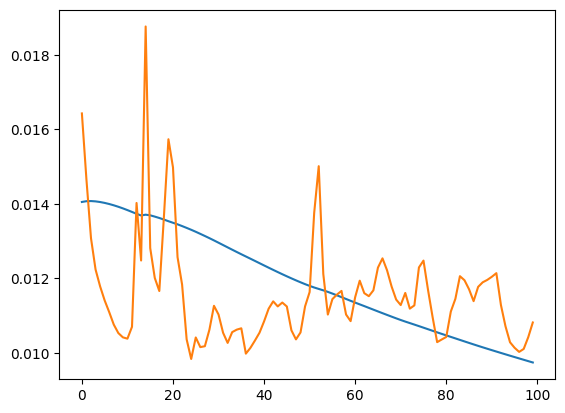

In [485]:
train()

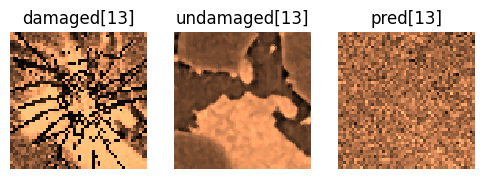

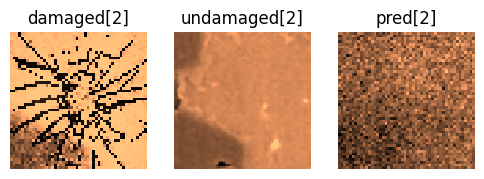

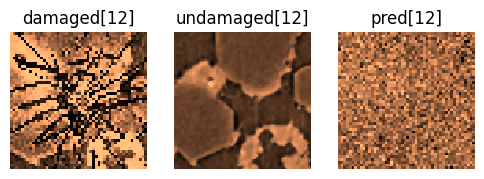

In [531]:
def predict(x):
    return model(Tensor(x.reshape(-1))).detach().numpy().reshape(50,50)


ds = [x_test,y_test]
# ds = [x_train,y_train]

for i in np.random.choice(len(ds[0]),3,False):
    plt.figure(figsize=(6, 2))

    plt.subplot(131)
    plt.axis("off")
    plt.imshow(ds[0][i], interpolation="none")
    plt.title(f"damaged[{i}]")

    plt.subplot(132)
    plt.axis("off")
    plt.imshow(ds[1][i], interpolation="none")
    plt.title(f"undamaged[{i}]")

    plt.subplot(133)
    plt.axis("off")
    plt.imshow(predict(ds[0][i]), interpolation="none")
    plt.title(f"pred[{i}]")

    plt.show()



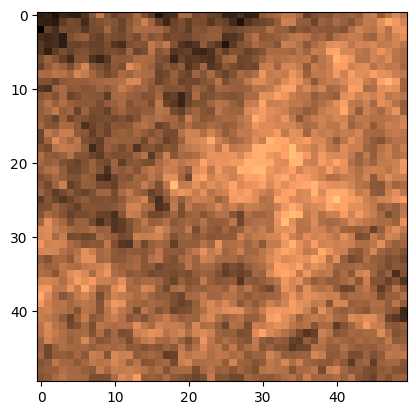

In [494]:
imshow(model(x_test[0]).detach().numpy().reshape((50,50)))

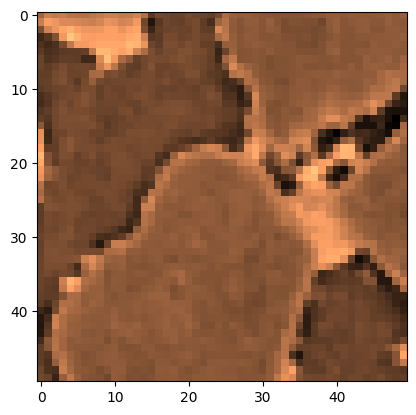

In [495]:
imshow(downsize(y_test[0].reshape(1,100,100))[0])